# Capsule Network for Graphical Perception of Treemaps

## 1: Data Reader

The dataset is loaded into the network as pickle files. The input files consist of a dictionary with the following features:
 - *features* is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
 - *labels* is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.   

(Copied from original repo)

### Dataset Summary

The dataset is constructed as follows:  
 - *training-images* consists of 11,197 randomly generated treemaps (with data point) with resolution 300x300 in PNG format.  
 - *validation-images*  consists of 3,756 randomly generated treemaps.
 - *test-images*  consists of 3,729 randomly generated treemaps.

![graphs](graphs.png)

## 2: Model & Network Architecture

### Capsule Network layers
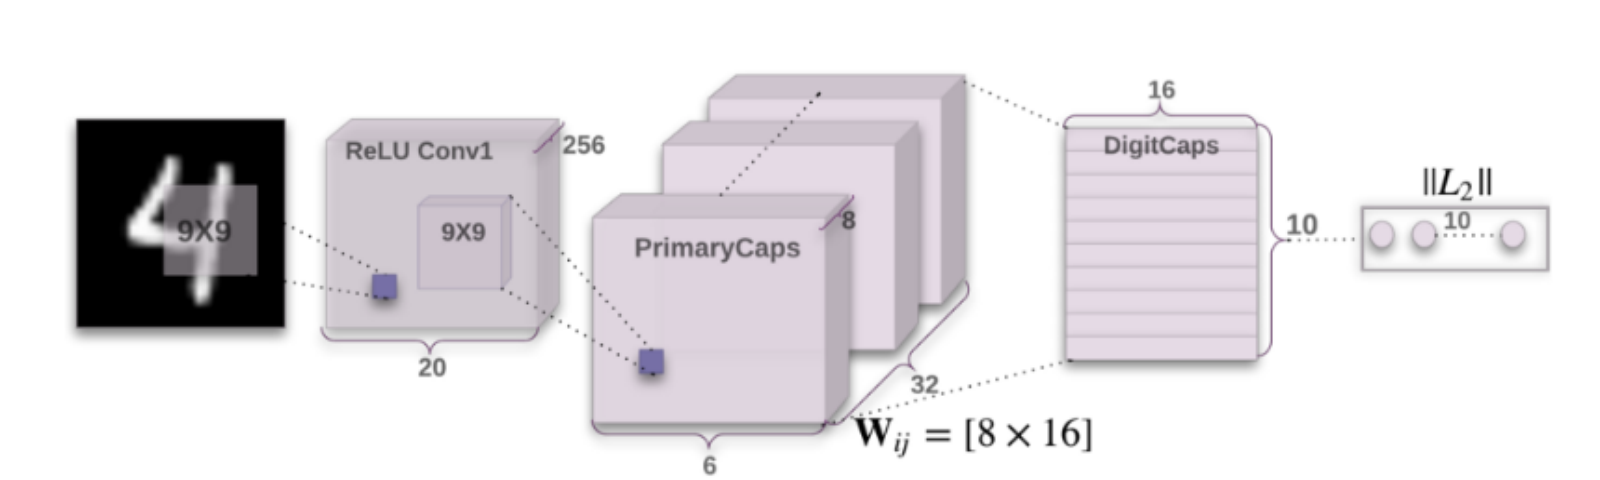

The above image shows the typical architecture of a capsule network (in this case, digit analysis). This network implements the network in the same manner as the paper by Hinton et al. The input data features are extracted by the first (convolutional) layer using 256 9x9 kernels, using a dropout rate of 0.7 and ReLU layer (which introduces nonlinearity).
```python
# Layer 1: Convolution.
shape = (self.h.conv_1_size, self.h.conv_1_size, 3, self.h.conv_1_nb)
conv1 = self._create_conv(self.tf_images, shape, relu=True, max_pooling=False, padding='VALID')
conv1 = tf.nn.dropout(conv1, keep_prob=conv_2_dropout)
# With hyperparameters:
"conv_1_size": 9,
"conv_1_nb": 256,
"conv_2_dropout": 0.7,
```

*add tensorflow functions & routing/squashing?*

Then the convoluted input features are passed to the first capsule layer (caps1). This layer is a so-called convolutional capsule layer. This layer consists of 16 channels of 16D capsules (16 convolutional units of 5x5 kernels). These capsules reads the convolutional input layer, whose kernel overlaps with the center of the capsule. Then, the fully-connected capsule layer caps2 reads the output of caps1, using 32 channels of 16D capsules.
```python
# Create the first capsules layer
caps1 = conv_caps_layer(
   input_layer=conv1,
   capsules_size=self.h.caps_1_vec_len,
   nb_filters=self.h.caps_1_nb_filter,
   kernel=self.h.caps_1_size)
# Create the second capsules layer used to predict the output
   caps2 = fully_connected_caps_layer(
   input_layer=caps1,
   capsules_size=self.h.caps_2_vec_len,
   nb_capsules=self.NB_LABELS,
   iterations=self.h.routing_steps)
return caps1, caps2
# With hyperparameters:
"caps_1_vec_len": 16,
"caps_1_size": 5,
"caps_1_nb_filter": 16,
"caps_2_vec_len": 32,
"learning_rate": 0.0001,
"routing_steps": 1
```

### Decoder function
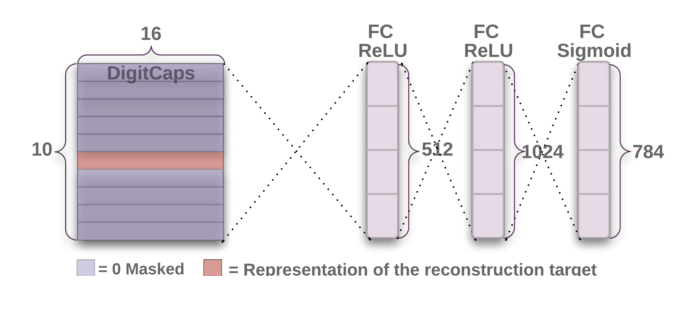

The image above shows the decoder structure for the Hinton paper. The decoder reconstructs the image from the output of the fully-connected capsule layer. It does this in three layers, first from the original 5x5 kernels to 8x8, then 16x16, then to the original (processed) input size of 32x32. 
The target of the reconstruction is the true label.
```python
def _build_decoder(self, caps2, one_hot_labels, batch_size):
    """
        Build the decoder part from the last capsule layer
        **input:
            *Caps2:  Output of second Capsule layer
            *one_hot_labels
            *batch_size
    """
    labels = tf.reshape(one_hot_labels, (-1, self.NB_LABELS, 1))
    mask = tf.matmul(tf.squeeze(caps2), labels, transpose_a=True)
    # Select the good capsule vector
    capsule_vector = tf.reshape(mask, shape=(batch_size, self.h.caps_2_vec_len))

    # Reconstruct image
    fc1 = tf.contrib.layers.fully_connected(capsule_vector, num_outputs=400)
    fc1 = tf.reshape(fc1, shape=(batch_size, 5, 5, 16))
    upsample1 = tf.image.resize_nearest_neighbor(fc1, (8, 8))
    conv1 = tf.layers.conv2d(upsample1, 4, (3,3), padding='same', activation=tf.nn.relu)

    upsample2 = tf.image.resize_nearest_neighbor(conv1, (16, 16))
    conv2 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)

    upsample3 = tf.image.resize_nearest_neighbor(conv2, (32, 32))
    conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)

    # 3 channel for RGG
    logits = tf.layers.conv2d(conv6, 3, (3,3), padding='same', activation=None)
    decoded = tf.nn.sigmoid(logits, name='decoded')
    tf.summary.image('reconstruction_img', decoded)

return decoded
```